# Resolución ejercicio 4.6.40
### Análisis y diseño de algoritmos distribuidos en redes
### Andrés Montoro 5.169.779-1



Exercise 4.6.40


Se asumen las restricciones:
- BidirectionalLinks 
- Connectivity
- TotalReliability


In [1]:
from pydistsim.algorithm.node_algorithm import NodeAlgorithm, StatusValues
from pydistsim.algorithm.node_wrapper import NodeAccess
from pydistsim.message import Message
from pydistsim.restrictions.communication import BidirectionalLinks
from pydistsim.restrictions.reliability import TotalReliability
from pydistsim.restrictions.topological import Connectivity
from pydistsim.restrictions.knowledge import InitialDistinctValues

from pydistsim import NetworkGenerator, Simulation
from pydistsim.logging import set_log_level, LogLevels, enable_logger
from pydistsim.network.behavior import NetworkBehaviorModel
from pydistsim.gui import drawing as draw
%matplotlib inline
from matplotlib import pyplot as plt


## Stages

### Implementacion

In [ ]:
# Assume my guy x already knows: 
#     -Its children in Tr, 
#     -Its parent in Tr, 
#     -Its associated labels α(x) = (a, b) in Tr, 
#     -Its neighbors of x in G. edge (u0, v0).



class AllBridges(NodeAlgorithm):
    #Voy a asumir que todos los mensajes son en el formato deseado
    default_params = {
        "choice" : "Choice",
        "request" : "Request",
        "edge" : "Edge",
    }

    class Status(StatusValues):
        COMPUTING = "COMPUTING"
        SWAPPED = "SWAPPED"
        WAITING = "WAITING"

    S_init = (Status.COMPUTING)
    S_term = ()

    algorithm_restrictions = (
        BidirectionalLinks,
        Connectivity, 
        TotalReliability, 
        InitialDistinctValues
    )

    def error(self, method : str, message: Message):
        msj = 'Unexpected message in ' + method + message.header + " from " + str(message.source) + " , content: " + str(message.data)
        raise Exception(msj)


    def feasible(self, edge, ab):
        #FIXME
        (a, b) = ab
        return False

    def choose_min(self, node: NodeAccess, ab):
        #FIXME
        # (a, b) = ab
        # min_edge = None
        # min_distance = float('inf')
        # for edge, distance in node.memory["choice"].values():
        #     if distance < min_distance:
        #         min_distance = distance
        #         min_edge = edge
        # return min_edge, min_distance
        return None, 0

    def initializer(self):
        self.apply_restrictions()
        for node in self.network.nodes():
            node.status = self.Status.COMPUTING

            # FIXME asignar correctamente
            node.memory["children"] = []
            node.memory["parent"] = None
            node.memory["check"] = 0
            node.memory["choice"] = {}
            node.memory["count"] = 0
            node.memory["swap"] = {}
            node.memory["(a,b)"] = (0, 0) #deberia ser a y b reales

            node.push_to_inbox(Message(meta_header=NodeAlgorithm.INI, destination=node))


    @Status.COMPUTING
    def spontaneously(self, node: NodeAccess, message: Message):
        node.memory["count"] = 0
        if len(node.memory["children"]) == 0:
            mybridge, d = self.choose_min(node, node.memory["(a,b)"])
            self.send(
                node, 
                data=(mybridge, d),
                destination=node.memory["parent"],
                header=self.default_params["choice"]
            )
            node.status = self.Status.SWAPPED
        else:
            # me quedo esperando receiving
            pass


    @Status.COMPUTING
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["choice"]:
            [edge, distance] = message.data
            if self.feasible(edge, node.memory["(a,b)"]):
                node.memory["count"] += 1
                node.memory["choice"][message.source] = (edge, distance)
                if node.memory["count"] == len(node.memory["children"]):
                    mybridge, d = self.choose_min(node, node.memory["(a,b)"])
                    self.send(
                        node,
                        data=(mybridge, d), 
                        destination=node.memory["parent"],
                        header=self.default_params["choice"]
                    )
                    node.status = self.Status.SWAPPED
            else:
                self.send(
                    node,
                    data= node.memory["(a,b)"],
                    destination= message.source,
                    header= self.default_params["request"]
                )
        else:
            self.error("COMPUTING::receiving", message)


    @Status.SWAPPED
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["request"]:
            (p, q) = message.data
            edge, d = self.choose_min(node, (p, q))
            if len(node.memory["children"]) == 0:
                self.send(
                    node,
                    data= [edge, d],
                    destination= message.source,
                    header= self.default_params["choice"]
                )
            else:
                node.memory["check"] = 0
                for y in node.memory["children"]:
                    if not self.feasible(node.memory["swap"][y], (p,q)):
                        self.send(
                            node,
                            data= (p,q),
                            destination= y,
                            header= self.default_params["request"]
                        )
                        node.memory["check"] += 1
                    if node.memory["check"] > 0:
                        node.status = self.Status.WAITING
                    else:
                        (edge, d) = self.choose_min(node, (p,q))
                        self.send(
                            node,
                            data= (edge, d),
                            destination= list(node.memory["parent"]),
                            header= self.default_params["choice"]
                        )
        else:
            self.error("SWAPPED::receiving", message)

    @Status.WAITING
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["choice"]:
            [edge, distance] = message.data
            node.memory["choice"][message.source] = (edge, distance)
            check -= check
            if check == 0:
                (edge, d) = self.choose_min(node, node.memory["(a,b)"])
                self.send(
                    node,
                    data=(edge, d), 
                    destination=node.memory["parent"],
                    header=self.default_params["choice"]
                )
                node.status = self.Status.SWAPPED
        else:
            self.error("WAITING::receiving", message)


### Ejecución


2025-11-08 00:03:01.704 | INFO     | pydistsim.simulation:__init__:59 - Simulation 0x2039c20df70 created successfully.


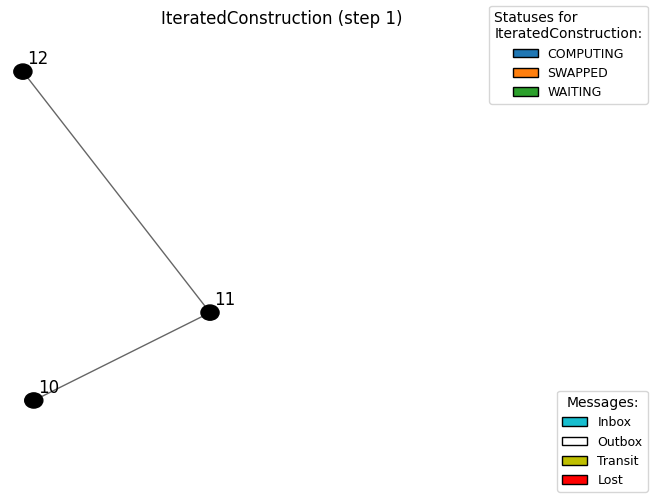

In [6]:
net_gen = NetworkGenerator(3, directed=False)
net = net_gen.generate_random_network()
sim = Simulation(net, check_restrictions=True)
sim.algorithms = (IteratedConstruction,)
set_log_level(LogLevels.INFO)
enable_logger()

fig = draw.draw_current_state(sim)
fig

Correr la siguiente celda hasta que termine de ejecutarse el algoritmo. Se indica en cada paso:
- El estado del grafo
- Informacion de cada nodo: id, estado, registros en memoria 

In [9]:
sim.run(1)


AttributeError: 'NoneType' object has no attribute 'unbox'

### Pruebas

In [ ]:
# ordered_nodes = sorted(net.nodes(), key=lambda n: n.memory["unique_value"])
# assert ordered_nodes[0].status == Stages.Status.LEADER
# assert all(n.status == Stages.Status.FOLLOWER for n in ordered_nodes[1:])
# print("OK")

## Otros

In [ ]:
sim.reset()
plt.close()